In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  2 14:46:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   56C    P3             22W /  100W |    5710MiB /   6144MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
from sklearn.model_selection import train_test_split

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-07-02 14:46:42.173907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-07-02 14:46:46.286978: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-02 14:46:46.287206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-02 14:46:46.297526: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-02 14:46:46.297559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: usuario-1-0
2024-07-02 14:46:46.297563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: usuario-1-0
2024-07-02 14:46:46.297757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.52.4
2024-07-02 14:46:46.297775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.52.4
2024-07-02 14:46:46.297778: I tensorflow/stream_executor/cuda/cuda_diagnostics

In [4]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=140 # Regla de tres: Tamaño del dataset experto----batch size

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=40000  # El experto en vez de 250000 tiene 20000 
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


In [5]:
#!cd pybox2d && python setup.py build && python setup.py install

In [6]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a,s',r] reales o sintéticas, de longitud 2*ob_space.shape[0] + ac_space.n+1.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 10)          220       
_________________________________________________________________
layer2 (Dense)               (None, None, 10)          110       
_________________________________________________________________
layer3 (Dense)               (None, None, 10)          110       
_________________________________________________________________
prob (Dense)                 (None, None, 1)           11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


2024-07-02 14:46:46.421983: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 14:46:46.423382: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, expert_s_prima, expert_r, agent_s, agent_a, agent_s_prima, agent_r):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net

        # -Experto: [s,a,s',r]
        self.expert_s=expert_s
        self.expert_a=expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)


        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)
        expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, expert_r], axis=1)

        # -Agente:  [s,a,s',r]
        self.agent_s=agent_s
        self.agent_a=agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)

        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a_s_r)

        #-Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation="sigmoid",name='layer1'),
        layers.Dense(units=6, activation="sigmoid", name='layer2'),
        layers.Dense(units=4, activation="sigmoid", name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 4)           28        
_________________________________________________________________
layer4 (Dense)               (None, None, 4)           20        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation="sigmoid",name='layer1'),
            layers.Dense(units=6, activation="sigmoid", name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 1)           7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env=env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    # Devuelve los parámetros \theta de la política \pi
    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] sinteticos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0

        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0

            truncated=False
            terminated=False


            # La primera acción de cada episodio se crea con la red neuronal
            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            truncated=False
            terminated=False

            # Tenemos una política entrenada
            Policy = Policy_net('policy',env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_1,s_2,s_3,...,s_8]] por eso su tamaño es (1,8)
                observations.append(next_obs)  # S_i-1

                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True or truncated==True:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                if success_num >= 100:
                    break
            else:
                success_num = 0



        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        next_observations = np.reshape(next_observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        # Devolvemos la secuencia (S,A,S',R) junto con la política anterior y la actual política,
        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen1=np.concatenate([generate_observations,generate_a_one_hot],axis=1)

        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)

        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):

        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        if generate_next_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        else:
           generate_next_observations_new= np.resize(generate_next_observations, generate_observations.shape)
           dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations_new], axis=1)

        rewards=np.array(rewards).reshape(-1,1)

        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento 
        #if len(dataset_gen) >= BATCH_SIZE: 
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices[0]]


        # 3) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento y las combinamos
        dataset_gen=dataset_gen.reshape(1,-1)
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat( [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0 )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )



        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations) #       generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

         ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}



# Experimentación de GAIL con LunarLander

## Experimento 1

### Construcción de base de datos experta con 1 trayectoria 

In [16]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [18]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [19]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [20]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [21]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [24]:
import copy

In [25]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2024-07-02 14:55:39.287438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-02 14:55:39.291151: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz





d_loss= 2.6523874

g_loss= 1.9720427
1/4 [======>.......................] - ETA: 26:33 - d_loss: 2.6524 - g_loss: 1.9720


d_loss= 2.643332

g_loss= -3.341455
2/4 [==============>...............] - ETA: 19:03 - d_loss: 2.6479 - g_loss: -0.6847


d_loss= 2.6530137

g_loss= -0.27035412
3/4 [=====================>........] - ETA: 9:20 - d_loss: 2.6496 - g_loss: -0.5466 


d_loss= 2.5857077

g_loss= 3.8639216
4/4 [==============================] - 2216s 562s/step - d_loss: 2.6336 - g_loss: 0.5560


### Evaluación de GAIL

In [26]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 16ms/step - loss: 0.8943 - accuracy: 0.8385
>Loss real: 
0.7097838521003723
>Loss fake: 
0.8942945003509521


Episode  0 Total reward: 98.04129354395558
Episode  1 Total reward: -202.8315181347553
Episode  2 Total reward: -103.80043635746108
Episode  3 Total reward: -125.60673613132195
Episode  4 Total reward: 105.16378763656743
Episode  5 Total reward: -113.71877039519029
Episode  6 Total reward: -183.95081721614213
Episode  7 Total reward: -124.4259511315467
Episode  8 Total reward: -93.36321447525047
Episode  9 Total reward: -58.250697451462386
Episode  10 Total reward: -90.27377943348459
Episode  11 Total reward: -0.5982304934907745
Episode  12 Total reward: -17.675017213424155
Episode  13 Total reward: 133.52826168564272
Episode  14 Total reward: -73.77895002891131
Episode  15 Total reward: 115.99684984953586
Episode  16 Total reward: 5.860016497192103
Episode  17 Total reward: 15.916198042197694
Episode  18 Total reward: -60.53724552540815
Episode  19 Total reward: -155.34370534291568
Episode  20 Total reward: -17.033321502535486
Episode  21 Total reward: -98.17876450385499
Episode  22 T

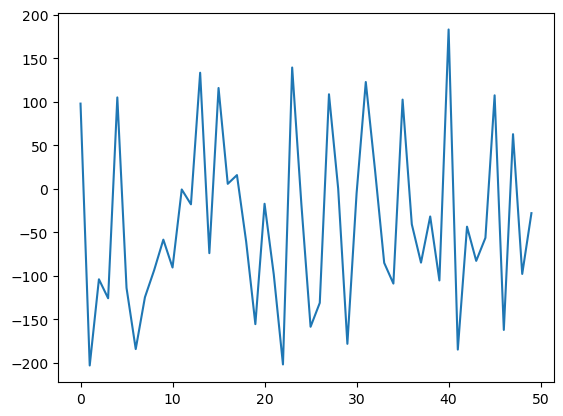


Recompensa de Media: -39.91959498515727 



In [27]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

### Construcción de base de datos experta con 2 trayectoria 

In [28]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [29]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [30]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [31]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [32]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [33]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [34]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [35]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.6126106

g_loss= 0.28688005
1/7 [===>..........................] - ETA: 1:02:40 - d_loss: 2.6126 - g_loss: 0.2869


d_loss= 2.5637934

g_loss= 0.2744208
2/7 [=======>......................] - ETA: 52:17 - d_loss: 2.5882 - g_loss: 0.2807  


d_loss= 2.6233482

g_loss= 0.65300083
3/7 [===========>..................] - ETA: 41:51 - d_loss: 2.5999 - g_loss: 0.4048


d_loss= 2.5651226

g_loss= -1.5215373
4/7 [================>.............] - ETA: 31:24 - d_loss: 2.5912 - g_loss: -0.0768


d_loss= 2.600709

g_loss= 1.4750057
5/7 [====================>.........] - ETA: 20:56 - d_loss: 2.5931 - g_loss: 0.2336 


d_loss= 2.6092846

g_loss= 0.5497137
6/7 [========================>.....] - ETA: 10:31 - d_loss: 2.5958 - g_loss: 0.2862


d_loss= 2.591103

g_loss= 1.1361111
7/7 [==============================] - 4414s 631s/step - d_loss: 2.5951 - g_loss: 0.4077


### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6447 - accuracy: 0.1667
>Loss real: 
0.706373393535614
>Loss fake: 
0.6446850299835205


Episode  0 Total reward: 71.85572613323642
Episode  1 Total reward: 15.837036654502285
Episode  2 Total reward: -136.2993725393409
Episode  3 Total reward: -60.682250799936405
Episode  4 Total reward: 56.34106943939117
Episode  5 Total reward: -88.13253155931835
Episode  6 Total reward: 6.345599641538826
Episode  7 Total reward: -1.041510638060501
Episode  8 Total reward: 113.15960910654351
Episode  9 Total reward: -58.46466281997603
Episode  10 Total reward: -64.10196624195075
Episode  11 Total reward: -217.22695854402994
Episode  12 Total reward: -234.92092755684277
Episode  13 Total reward: -11.611082862340524
Episode  14 Total reward: 17.90190638358571
Episode  15 Total reward: 27.948966187535667
Episode  16 Total reward: 2.9793351873499887
Episode  17 Total reward: -21.32607850053516
Episode  18 Total reward: 14.141006896301938
Episode  19 Total reward: 48.892853516847865
Episode  20 Total reward: 129.58451146764915
Episode  21 Total reward: -38.75449071239643
Episode  22 Total re

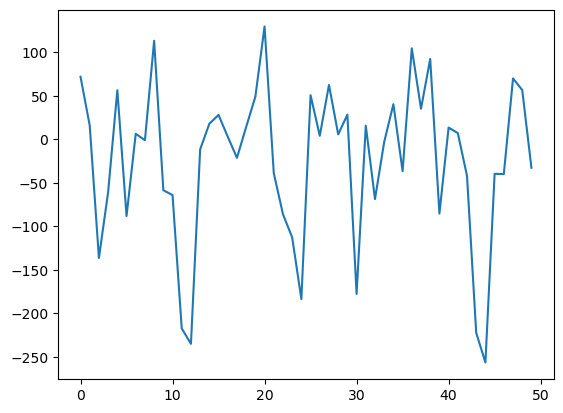


Recompensa de Media: -24.565050772648057 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

### Construcción de base de datos experta con 3 trayectoria 

In [39]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [40]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [41]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [42]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [43]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [44]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [45]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [46]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [47]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5869744

g_loss= 0.69448334
1/9 [==>...........................] - ETA: 1:04:11 - d_loss: 2.5870 - g_loss: 0.6945


d_loss= 2.6031098

g_loss= -2.7377539
2/9 [=====>........................] - ETA: 56:32 - d_loss: 2.5950 - g_loss: -1.0216 


d_loss= 2.5750742

g_loss= 2.415418
3/9 [=========>....................] - ETA: 44:14 - d_loss: 2.5884 - g_loss: 0.1240 


d_loss= 2.5509062

g_loss= 0.68319577
4/9 [============>.................] - ETA: 35:42 - d_loss: 2.5790 - g_loss: 0.2638


d_loss= 2.5985534

g_loss= -0.98786104
5/9 [===============>..............] - ETA: 28:05 - d_loss: 2.5829 - g_loss: 0.0135


d_loss= 2.574546

g_loss= 2.8376043
6/9 [===================>..........] - ETA: 20:52 - d_loss: 2.5815 - g_loss: 0.4842


d_loss= 2.5339694

g_loss= -2.28929
7/9 [======================>.......] - ETA: 13:49 - d_loss: 2.5747 - g_loss: 0.0880


d_loss= 2.5598602

g_loss= 0.864584
8/9 [=========================>....] - ETA: 6:52 - d_loss: 2.5729 - g_loss: 0.1850 


d_loss=

### Evaluación de GAIL

In [48]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 9ms/step - loss: 0.6486 - accuracy: 0.2833
>Loss real: 
0.6376952528953552
>Loss fake: 
0.6486262083053589


Episode  0 Total reward: -21.258838030891184
Episode  1 Total reward: -94.31099323240255
Episode  2 Total reward: -100.42983974815677
Episode  3 Total reward: 128.6583104750983
Episode  4 Total reward: 69.35335199962672
Episode  5 Total reward: -103.29830700222898
Episode  6 Total reward: 106.73457699323279
Episode  7 Total reward: 21.342789683236987
Episode  8 Total reward: -52.216164768297645
Episode  9 Total reward: 89.09574872769012
Episode  10 Total reward: 104.90118424791373
Episode  11 Total reward: 35.34748055059393
Episode  12 Total reward: -68.38174960421631
Episode  13 Total reward: -5.188451845239243
Episode  14 Total reward: -82.97076980002254
Episode  15 Total reward: -88.72676124677396
Episode  16 Total reward: -120.93674785803188
Episode  17 Total reward: -86.69864549307495
Episode  18 Total reward: 78.57539909576194
Episode  19 Total reward: 54.58391004167262
Episode  20 Total reward: -12.073319929157691
Episode  21 Total reward: -65.1802644857569
Episode  22 Total rew

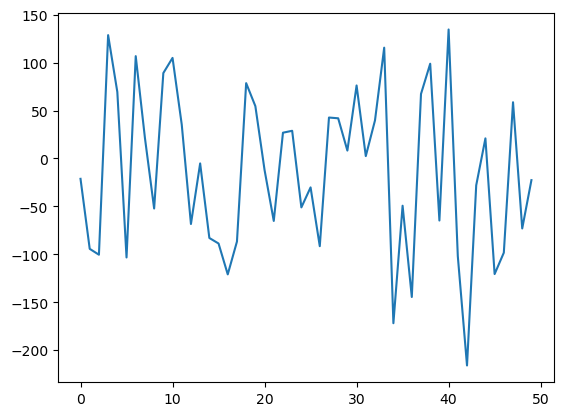


Recompensa de Media: -14.28467856305181 



In [49]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

### Construcción de base de datos experta con 4 trayectoria 

In [50]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [51]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [52]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [53]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [54]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [55]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [56]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [57]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5474615

g_loss= -1.3547312
 1/13 [=>............................] - ETA: 2:04:47 - d_loss: 2.5475 - g_loss: -1.3547


d_loss= 2.5195522

g_loss= 1.358638
 2/13 [===>..........................] - ETA: 1:55:17 - d_loss: 2.5335 - g_loss: 0.0020 


d_loss= 2.5349505

g_loss= 3.3267617
 3/13 [=====>........................] - ETA: 1:44:50 - d_loss: 2.5340 - g_loss: 1.1102


d_loss= 2.5660439

g_loss= 2.1828837
 4/13 [========>.....................] - ETA: 1:34:28 - d_loss: 2.5420 - g_loss: 1.3784


d_loss= 2.6124744

g_loss= -0.51852167
 5/13 [==========>...................] - ETA: 1:24:07 - d_loss: 2.5561 - g_loss: 0.9990


d_loss= 2.532445

g_loss= 1.0698951
 6/13 [============>.................] - ETA: 1:13:36 - d_loss: 2.5522 - g_loss: 1.0108


d_loss= 2.5527377

g_loss= 3.062141
 7/13 [===============>..............] - ETA: 1:03:07 - d_loss: 2.5522 - g_loss: 1.3039


d_loss= 2.554758

g_loss= 0.7253308
 8/13 [=================>............] - ETA: 52:38 - d_loss: 2.5526 -

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6076 - accuracy: 0.0000e+00
>Loss real: 
0.6223491430282593
>Loss fake: 
0.607596218585968


Episode  0 Total reward: -20.55237690713666
Episode  1 Total reward: 47.9567391225452
Episode  2 Total reward: 58.5064429096731
Episode  3 Total reward: -15.628172840705531
Episode  4 Total reward: -99.7808453416373
Episode  5 Total reward: -89.48992180962732
Episode  6 Total reward: 37.740649038773455
Episode  7 Total reward: 12.041819503110375
Episode  8 Total reward: -98.33723785052321
Episode  9 Total reward: -131.2450373513612
Episode  10 Total reward: -83.98167122828004
Episode  11 Total reward: -122.60738207164309
Episode  12 Total reward: -47.17594622994296
Episode  13 Total reward: -106.67931472938511
Episode  14 Total reward: -61.652991766106226
Episode  15 Total reward: 12.177032890975124
Episode  16 Total reward: -20.404166144709322
Episode  17 Total reward: 21.520434150083247
Episode  18 Total reward: -84.78149726922621
Episode  19 Total reward: -144.33790224129802
Episode  20 Total reward: 51.15857670300004
Episode  21 Total reward: -251.85607848924718
Episode  22 Total r

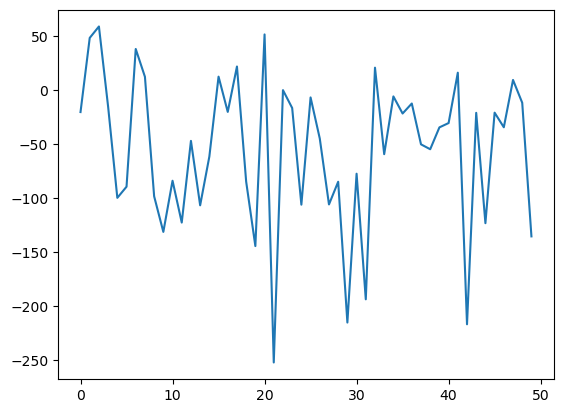


Recompensa de Media: -55.575640795824754 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

### Construcción de base de datos experta con 2 trayectoria 

In [61]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [62]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [63]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [64]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [65]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [66]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [67]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [68]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [69]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.4844127

g_loss= 0.08664101
 1/19 [>.............................] - ETA: 1:59:53 - d_loss: 2.4844 - g_loss: 0.0866


d_loss= 2.475728

g_loss= 0.8358883
 2/19 [==>...........................] - ETA: 1:53:27 - d_loss: 2.4801 - g_loss: 0.4613


d_loss= 2.5088036

g_loss= -0.15271276
 3/19 [===>..........................] - ETA: 1:46:48 - d_loss: 2.4896 - g_loss: 0.2566


d_loss= 2.530171

g_loss= -0.118153654
 4/19 [=====>........................] - ETA: 1:40:06 - d_loss: 2.4998 - g_loss: 0.1629


d_loss= 2.458501

g_loss= 1.8967965
 5/19 [======>.......................] - ETA: 1:33:26 - d_loss: 2.4915 - g_loss: 0.5097


d_loss= 2.4795847

g_loss= -0.069746606
 6/19 [========>.....................] - ETA: 1:26:47 - d_loss: 2.4895 - g_loss: 0.4131


d_loss= 2.4751456

g_loss= -4.288805
 7/19 [==========>...................] - ETA: 1:20:07 - d_loss: 2.4875 - g_loss: -0.2586


d_loss= 2.446813

g_loss= 4.136402
 8/19 [===========>..................] - ETA: 1:13:27 - d_loss: 2.

### Evaluación de GAIL

In [70]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 10ms/step - loss: 0.4702 - accuracy: 0.0562
>Loss real: 
0.49768924713134766
>Loss fake: 
0.47024014592170715


Episode  0 Total reward: -92.64886896380568
Episode  1 Total reward: -124.60601061611129
Episode  2 Total reward: -61.36257746497229
Episode  3 Total reward: -180.9324271574233
Episode  4 Total reward: -31.65917376909499
Episode  5 Total reward: -26.60490672089844
Episode  6 Total reward: -191.97140160712877
Episode  7 Total reward: 76.4014342963731
Episode  8 Total reward: -48.97143817013199
Episode  9 Total reward: -127.03324270171073
Episode  10 Total reward: -203.2947018331895
Episode  11 Total reward: -84.06658379310576
Episode  12 Total reward: -158.65298112904202
Episode  13 Total reward: -50.22245020676167
Episode  14 Total reward: -151.80959754159807
Episode  15 Total reward: -74.4069878341364
Episode  16 Total reward: -18.030863629835736
Episode  17 Total reward: -183.54855485659496
Episode  18 Total reward: 65.38094544543797
Episode  19 Total reward: 18.06978673236301
Episode  20 Total reward: -68.25194008988613
Episode  21 Total reward: 26.18638481999229
Episode  22 Total r

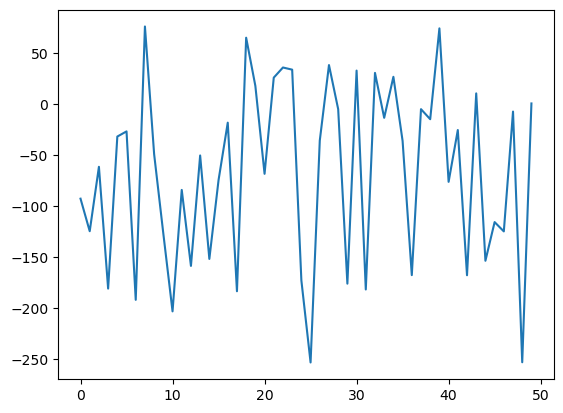


Recompensa de Media: -67.82084546198611 



In [71]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

### Construcción de base de datos experta con 6 trayectoria 

In [72]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [73]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [74]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [75]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [76]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [77]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [78]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [79]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

### Evaluación de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.465796

g_loss= 3.412959
 1/24 [>.............................] - ETA: 4:02:13 - d_loss: 2.4658 - g_loss: 3.4130


d_loss= 2.4340496

g_loss= 1.7210047
 2/24 [=>............................] - ETA: 3:50:36 - d_loss: 2.4499 - g_loss: 2.5670


d_loss= 2.463148

g_loss= -8.109693
 3/24 [==>...........................] - ETA: 3:40:18 - d_loss: 2.4543 - g_loss: -0.9919


d_loss= 2.4646087

g_loss= 3.50794
 4/24 [====>.........................] - ETA: 3:29:59 - d_loss: 2.4569 - g_loss: 0.1331 


d_loss= 2.4482203

g_loss= 1.6177206
 5/24 [=====>........................] - ETA: 3:19:43 - d_loss: 2.4552 - g_loss: 0.4300


d_loss= 2.3968487

g_loss= -2.7182665
 6/24 [======>.......................] - ETA: 3:09:23 - d_loss: 2.4454 - g_loss: -0.0947


d_loss= 2.4437656

g_loss= -0.18237545
 7/24 [=======>......................] - ETA: 2:58:54 - d_loss: 2.4452 - g_loss: -0.1072


d_loss= 2.4387355

g_loss= 1.130614
 8/24 [=========>....................] - ETA: 2:48:22 - d_loss: 2.4444

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.4649 - accuracy: 0.0000e+00
>Loss real: 
0.45526251196861267
>Loss fake: 
0.46493685245513916


Episode  0 Total reward: 49.614992887832585
Episode  1 Total reward: -72.26972885802738
Episode  2 Total reward: -1.1400129929320286
Episode  3 Total reward: -18.385077194727202
Episode  4 Total reward: -6.995822928518521
Episode  5 Total reward: 110.92016951295429
Episode  6 Total reward: -130.3635086843739
Episode  7 Total reward: -0.7858132460605276
Episode  8 Total reward: -40.41473685176731
Episode  9 Total reward: -31.581267810599783
Episode  10 Total reward: 15.34487932624259
Episode  11 Total reward: 3.698089874608799
Episode  12 Total reward: -79.15635246836943
Episode  13 Total reward: -39.23973735684007
Episode  14 Total reward: -58.13214965139417
Episode  15 Total reward: -49.57215285686158
Episode  16 Total reward: -20.478109492987286
Episode  17 Total reward: 27.165625215278084
Episode  18 Total reward: -36.00916876077777
Episode  19 Total reward: 13.0681604512951
Episode  20 Total reward: -133.57523008968556
Episode  21 Total reward: -1.746934585387628
Episode  22 Total 

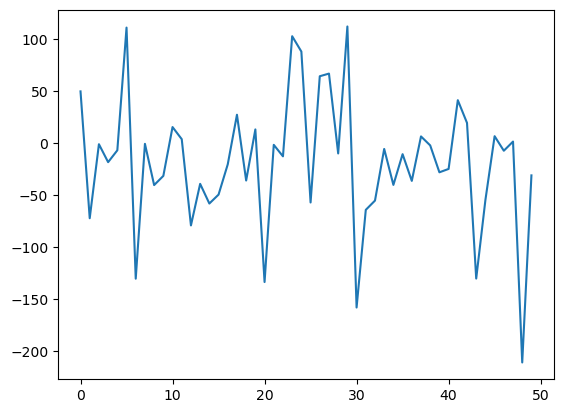


Recompensa de Media: -18.64159356294645 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

### Construcción de base de datos experta con 7 trayectoria 

In [83]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [84]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [85]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [86]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [87]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [88]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [89]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [90]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.3759208

g_loss= 0.41692293
 1/27 [>.............................] - ETA: 4:35:48 - d_loss: 2.3759 - g_loss: 0.4169


d_loss= 2.3713899

g_loss= 0.061330676
 2/27 [=>............................] - ETA: 4:26:13 - d_loss: 2.3737 - g_loss: 0.2391


d_loss= 2.3411994

g_loss= -4.24168
 3/27 [==>...........................] - ETA: 4:16:53 - d_loss: 2.3628 - g_loss: -1.2545


d_loss= 2.3650389

g_loss= -4.116773
 4/27 [===>..........................] - ETA: 4:05:00 - d_loss: 2.3634 - g_loss: -1.9700


d_loss= 2.344535

g_loss= 2.0137851
 5/27 [====>.........................] - ETA: 3:53:31 - d_loss: 2.3596 - g_loss: -1.1733


d_loss= 2.3445194

g_loss= 0.23508817
 6/27 [=====>........................] - ETA: 3:42:39 - d_loss: 2.3571 - g_loss: -0.9386


d_loss= 2.3336897

g_loss= -0.7506277
 7/27 [======>.......................] - ETA: 3:31:55 - d_loss: 2.3538 - g_loss: -0.9117


d_loss= 2.2907

g_loss= 3.512479
 8/27 [=======>......................] - ETA: 3:21:12 - d_loss: 2.3

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.2852 - accuracy: 0.0000e+00
>Loss real: 
0.3338671028614044
>Loss fake: 
0.2852312922477722


Episode  0 Total reward: -88.370858572964
Episode  1 Total reward: -117.04034467417604
Episode  2 Total reward: -206.98803273041028
Episode  3 Total reward: 45.75899463859486
Episode  4 Total reward: -195.70597891581247
Episode  5 Total reward: -128.09387532557156
Episode  6 Total reward: -42.054682631027006
Episode  7 Total reward: 9.743566555436402
Episode  8 Total reward: -81.16957064721942
Episode  9 Total reward: 20.720311756427513
Episode  10 Total reward: 2.940022449135057
Episode  11 Total reward: -198.82565477660802
Episode  12 Total reward: -172.11147739860922
Episode  13 Total reward: 65.68098756501541
Episode  14 Total reward: -13.355258798637493
Episode  15 Total reward: -216.89313806267484
Episode  16 Total reward: 36.04001013991979
Episode  17 Total reward: -227.5957654647936
Episode  18 Total reward: -48.29967415450177
Episode  19 Total reward: -58.25638654399516
Episode  20 Total reward: -101.16685405719623
Episode  21 Total reward: 31.453382569805864
Episode  22 Total

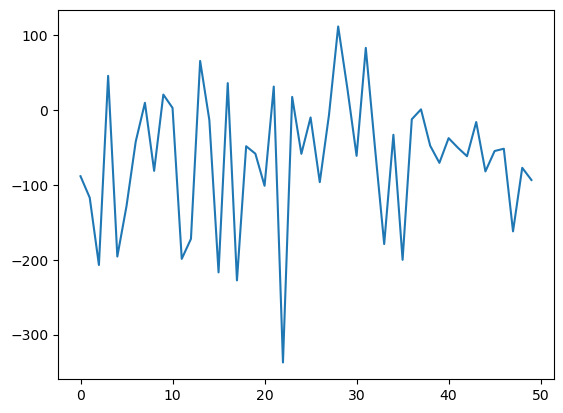


Recompensa de Media: -65.79890709771627 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

### Construcción de base de datos experta con 8 trayectoria 

In [94]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [95]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [96]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [97]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [98]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [99]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [100]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [101]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [102]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.2010288

g_loss= 2.024493
 1/31 [..............................] - ETA: 3:20:40 - d_loss: 2.2010 - g_loss: 2.0245


d_loss= 2.1840796

g_loss= 0.43196383
 2/31 [>.............................] - ETA: 3:14:47 - d_loss: 2.1926 - g_loss: 1.2282


d_loss= 2.2153928

g_loss= 2.6254416
 3/31 [=>............................] - ETA: 3:07:58 - d_loss: 2.2002 - g_loss: 1.6940


d_loss= 2.1971178

g_loss= 0.879769
 4/31 [==>...........................] - ETA: 3:01:14 - d_loss: 2.1994 - g_loss: 1.4904


d_loss= 2.2133534

g_loss= 2.3090777
 5/31 [===>..........................] - ETA: 2:54:28 - d_loss: 2.2022 - g_loss: 1.6541


d_loss= 2.1816864

g_loss= 0.88187116
 6/31 [====>.........................] - ETA: 2:47:47 - d_loss: 2.1988 - g_loss: 1.5254


d_loss= 2.1746693

g_loss= 1.0430481
 7/31 [=====>........................] - ETA: 2:41:08 - d_loss: 2.1953 - g_loss: 1.4565


d_loss= 2.174424

g_loss= -8.503985
 8/31 [======>.......................] - ETA: 2:34:24 - d_loss: 2.1927 -

### Evaluación de GAIL

In [103]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 9ms/step - loss: 0.1985 - accuracy: 0.0000e+00
>Loss real: 
0.18163831532001495
>Loss fake: 
0.1984775811433792


Episode  0 Total reward: -14.042319369830238
Episode  1 Total reward: -55.95048246062163
Episode  2 Total reward: 0.7781849879591363
Episode  3 Total reward: -68.41185346255747
Episode  4 Total reward: -37.52052327299291
Episode  5 Total reward: -5.344117572350022
Episode  6 Total reward: -11.487161221416116
Episode  7 Total reward: -126.29038261599192
Episode  8 Total reward: -31.15640925264485
Episode  9 Total reward: -28.39511815430069
Episode  10 Total reward: 59.82705151286653
Episode  11 Total reward: -10.390735073074438
Episode  12 Total reward: -57.32368437672749
Episode  13 Total reward: -133.52538765888065
Episode  14 Total reward: 83.56179377927495
Episode  15 Total reward: -22.627811430792136
Episode  16 Total reward: -7.083043793037049
Episode  17 Total reward: -5.464535582231008
Episode  18 Total reward: -37.416035767477
Episode  19 Total reward: 94.83807901251016
Episode  20 Total reward: -14.070904906009787
Episode  21 Total reward: 64.98530699461061
Episode  22 Total r

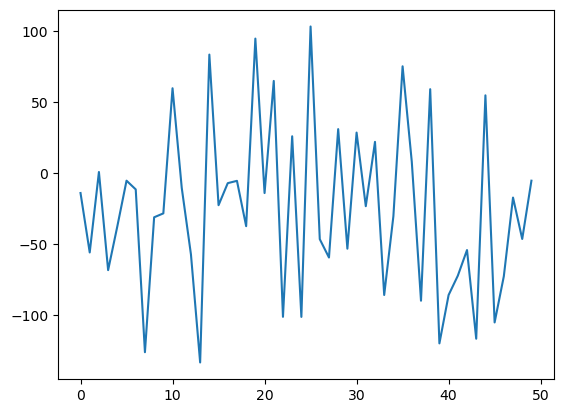


Recompensa de Media: -24.8535378283737 



In [104]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

### Construcción de base de datos experta con 9 trayectoria 

In [105]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [106]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [107]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [108]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [109]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [110]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [111]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [112]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [113]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.0606902

g_loss= 0.01537659
 1/34 [..............................] - ETA: 3:40:40 - d_loss: 2.0607 - g_loss: 0.0154


d_loss= 2.107381

g_loss= -0.42798325
 2/34 [>.............................] - ETA: 3:34:28 - d_loss: 2.0840 - g_loss: -0.2063


d_loss= 2.0247266

g_loss= 3.503713
 3/34 [=>............................] - ETA: 3:27:48 - d_loss: 2.0643 - g_loss: 1.0304 


d_loss= 2.0377452

g_loss= 1.0993272
 4/34 [==>...........................] - ETA: 3:21:04 - d_loss: 2.0576 - g_loss: 1.0476


d_loss= 2.04638

g_loss= 1.3597217
 5/34 [===>..........................] - ETA: 3:14:28 - d_loss: 2.0554 - g_loss: 1.1100


d_loss= 2.066523

g_loss= 2.5716896
 6/34 [====>.........................] - ETA: 3:07:44 - d_loss: 2.0572 - g_loss: 1.3536


d_loss= 2.0432575

g_loss= -6.5759783
 7/34 [=====>........................] - ETA: 3:01:02 - d_loss: 2.0552 - g_loss: 0.2208


d_loss= 2.0424845

g_loss= 2.2966993
 8/34 [======>.......................] - ETA: 2:54:19 - d_loss: 2.0536

### Evaluación de GAIL

In [114]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 11ms/step - loss: 0.0904 - accuracy: 0.0000e+00
>Loss real: 
0.0840177908539772
>Loss fake: 
0.09036680310964584


Episode  0 Total reward: 79.24362729412279
Episode  1 Total reward: -63.1493005667825
Episode  2 Total reward: -14.480586512811298
Episode  3 Total reward: 15.314781837800878
Episode  4 Total reward: -91.27593423144793
Episode  5 Total reward: -21.937011447521517
Episode  6 Total reward: 61.183702663842695
Episode  7 Total reward: -4.517359915513751
Episode  8 Total reward: -120.05848955649039
Episode  9 Total reward: -85.15237193740475
Episode  10 Total reward: 54.75625099063069
Episode  11 Total reward: 34.14448472439835
Episode  12 Total reward: -64.76319171906498
Episode  13 Total reward: 33.83934152756666
Episode  14 Total reward: 10.766322744874532
Episode  15 Total reward: -54.32888308088813
Episode  16 Total reward: -146.20716155378406
Episode  17 Total reward: -95.87866401727148
Episode  18 Total reward: -3.0297863538681895
Episode  19 Total reward: 80.95230535802912
Episode  20 Total reward: -51.22317488588142
Episode  21 Total reward: -99.53906662868522
Episode  22 Total rew

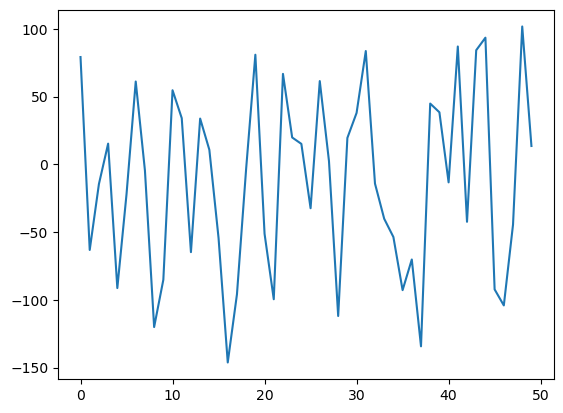


Recompensa de Media: -12.410900020735172 



In [115]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

### Construcción de base de datos experta con 10 trayectoria 

In [116]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [117]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [118]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [119]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [120]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [121]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [122]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [123]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [124]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


BATCH_SIZE=140

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.007844

g_loss= -0.12515092
 1/37 [..............................] - ETA: 4:37:09 - d_loss: 2.0078 - g_loss: -0.1252


d_loss= 1.9721657

g_loss= -0.7961289
 2/37 [>.............................] - ETA: 4:56:47 - d_loss: 1.9900 - g_loss: -0.4606


d_loss= 1.9708804

g_loss= 1.4756274
 3/37 [=>............................] - ETA: 4:24:36 - d_loss: 1.9836 - g_loss: 0.1848 


d_loss= 1.9685788

g_loss= 5.0844526
 4/37 [==>...........................] - ETA: 4:09:31 - d_loss: 1.9799 - g_loss: 1.4097


d_loss= 1.9968041

g_loss= -0.76817405
 5/37 [===>..........................] - ETA: 3:57:42 - d_loss: 1.9833 - g_loss: 0.9741


d_loss= 1.9588656

g_loss= 0.5382145
 6/37 [===>..........................] - ETA: 3:46:42 - d_loss: 1.9792 - g_loss: 0.9015


d_loss= 1.9642129

g_loss= -2.9898279
 7/37 [====>.........................] - ETA: 3:37:46 - d_loss: 1.9771 - g_loss: 0.3456


d_loss= 1.9365454

g_loss= 1.9218733
 8/37 [=====>........................] - ETA: 3:28:59 - d_loss:

### Evaluación de GAIL

In [125]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 12ms/step - loss: 0.0514 - accuracy: 0.0000e+00
>Loss real: 
0.03382343053817749
>Loss fake: 
0.0513639897108078


Episode  0 Total reward: -64.97239294067826
Episode  1 Total reward: 18.262929829612062
Episode  2 Total reward: -56.11649226045513
Episode  3 Total reward: -108.29803962011013
Episode  4 Total reward: -6.359245635937384
Episode  5 Total reward: 65.527805277073
Episode  6 Total reward: -67.58803814087288
Episode  7 Total reward: -3.666409170131132
Episode  8 Total reward: -81.93721953635053
Episode  9 Total reward: -213.83822340424945
Episode  10 Total reward: -35.845001802237434
Episode  11 Total reward: -171.2778365366221
Episode  12 Total reward: -34.50312474662364
Episode  13 Total reward: -28.95773806547743
Episode  14 Total reward: -3.40414795983844
Episode  15 Total reward: 4.968175509092632
Episode  16 Total reward: -5.972269823114587
Episode  17 Total reward: -48.586354584023155
Episode  18 Total reward: 36.30208560674595
Episode  19 Total reward: -3.046578088921521
Episode  20 Total reward: -200.40707517610826
Episode  21 Total reward: 45.34156885350883
Episode  22 Total rewa

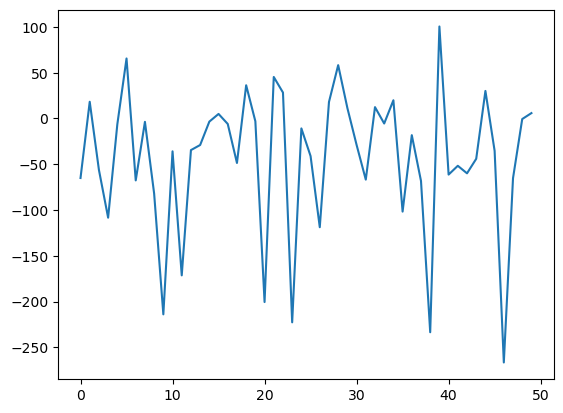


Recompensa de Media: -43.58872364851877 



In [130]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')